In [3]:
%reload_ext autoreload
%autoreload 2

In [8]:
import autorootcwd
import torch
from tqdm import tqdm

from src.utils import chord_to_id_map, id_to_chord_map, get_torch_device
from src.models.ismir2017 import ISMIR2017ACR
from src.data.dataset import FullChordDataset

In [12]:
import os
print(os.listdir('./data/experiments/ismir2017-lr-0.001'))

['metrics.json', 'metadata.json', 'best_model.pth', 'training_args.json', 'training_history.json']


In [5]:
state_dict = torch.load('./data/experiments/ismir2017-lr-0.001/best_model.pth', weights_only=True)

In [6]:
model = ISMIR2017ACR(cr2=False)
model.load_state_dict(state_dict)
model.eval()

ISMIR2017ACR(
  (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(1, 36, kernel_size=(1, 216), stride=(1, 1))
  (bi_gru_encoder): GRU(36, 256, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=512, out_features=25, bias=True)
)

In [26]:
dataset = FullChordDataset()

dataset[0][0].shape

torch.Size([2323, 216])

In [54]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from tqdm import tqdm

all_preds = []
all_labels = []

for i in tqdm(range(len(dataset))):
    cqt, label = dataset[i]
    pred = model(cqt.unsqueeze(0))
    preds = torch.argmax(pred, dim=2)
    all_preds.extend(preds[0].tolist())  # Collect predictions
    all_labels.extend(label.tolist())   # Collect true labels

100%|██████████| 1213/1213 [10:28<00:00,  1.93it/s]


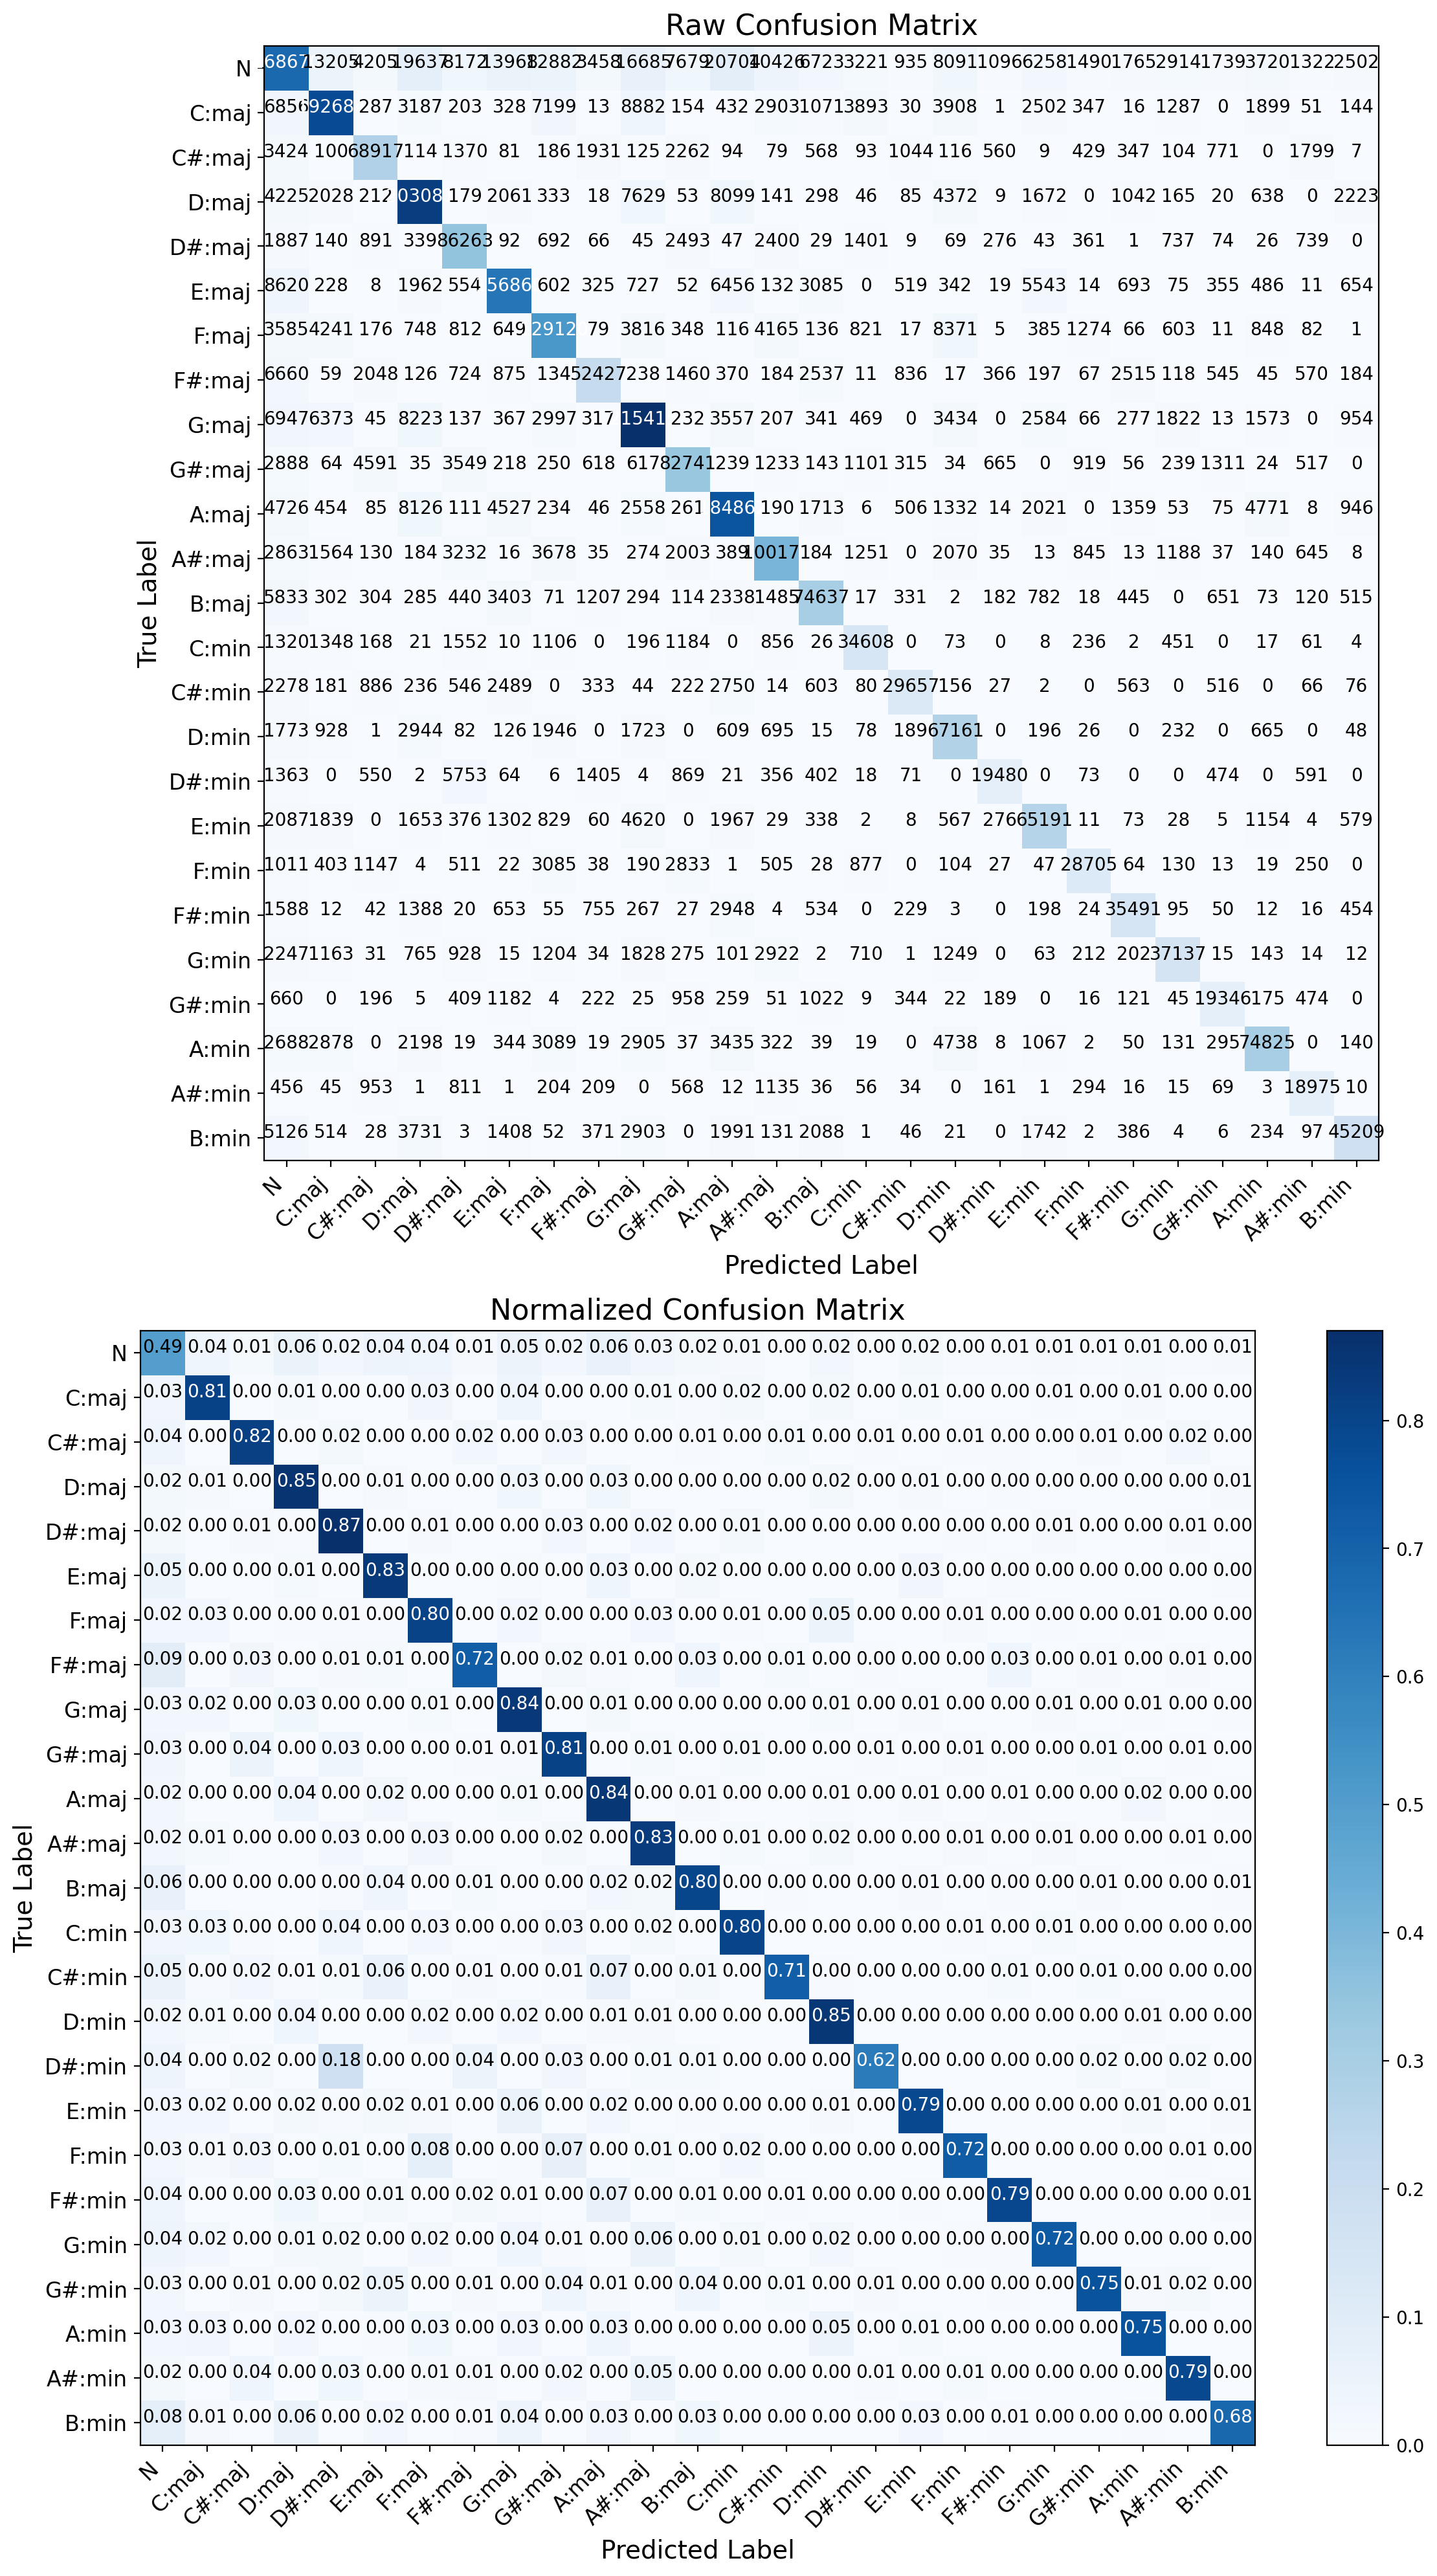

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix and normalized confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Map IDs to chord labels
chord_labels = [id_to_chord_map[id] for id in range(len(id_to_chord_map))]

# Create a larger figure and stack the plots vertically
fig, axes = plt.subplots(2, 1, figsize=(12, 20))

# Raw confusion matrix
axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title("Raw Confusion Matrix", fontsize=16)
axes[0].set_xticks(np.arange(len(chord_labels)))
axes[0].set_yticks(np.arange(len(chord_labels)))
axes[0].set_xticklabels(chord_labels, rotation=45, ha="right", fontsize=12)
axes[0].set_yticklabels(chord_labels, fontsize=12)
axes[0].set_ylabel('True Label', fontsize=14)
axes[0].set_xlabel('Predicted Label', fontsize=14)

# Add text to each cell for raw matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0].text(j, i, f"{cm[i, j]:d}", ha="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

# Normalized confusion matrix
im = axes[1].imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title("Normalized Confusion Matrix", fontsize=16)
axes[1].set_xticks(np.arange(len(chord_labels)))
axes[1].set_yticks(np.arange(len(chord_labels)))
axes[1].set_xticklabels(chord_labels, rotation=45, ha="right", fontsize=12)
axes[1].set_yticklabels(chord_labels, fontsize=12)
axes[1].set_ylabel('True Label', fontsize=14)
axes[1].set_xlabel('Predicted Label', fontsize=14)

# Add text to each cell for normalized matrix
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        axes[1].text(j, i, f"{cm_normalized[i, j]:.2f}", ha="center",
                     color="white" if cm_normalized[i, j] > 0.5 else "black")

# Add a colorbar to the normalized matrix
fig.colorbar(im, ax=axes[1])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

# Testing Context Lengths

Context length: 5


100%|██████████| 1697/1697 [04:12<00:00,  6.72it/s]


Context length: 10


100%|██████████| 850/850 [03:45<00:00,  3.76it/s]


Context length: 20


100%|██████████| 433/433 [05:12<00:00,  1.39it/s]


Context length: 60


100%|██████████| 157/157 [07:54<00:00,  3.02s/it] 


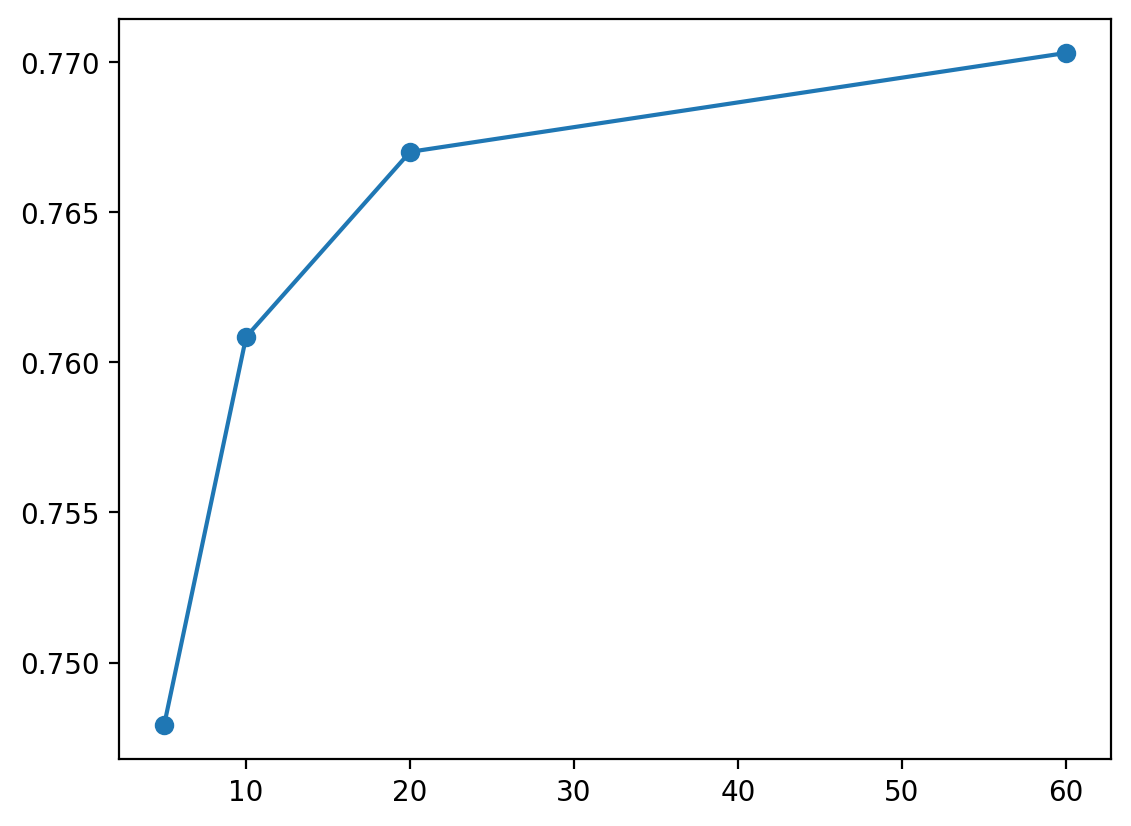

In [28]:
from src.data.dataset import FixedLengthChordDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import accuracy_score
from src.utils import collate_fn
import matplotlib.pyplot as plt

context_lengths = [5, 10, 20, 60]
accuracies = []
device = get_torch_device()
model.eval()
model.to(device)

for context_length in context_lengths:
    print(f"Context length: {context_length}")
    dataset = FixedLengthChordDataset(segment_length=context_length, cached=True)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    all_preds = []
    all_labels = []
    for batch_cqt, batch_labels in tqdm(loader):
        batch_cqt, batch_labels = batch_cqt.to(device), batch_labels.to(device)
        batch_preds = model(batch_cqt)
        batch_preds = torch.argmax(batch_preds, dim=2).cpu()
        all_preds.extend(torch.flatten(batch_preds).tolist())
        all_labels.extend(torch.flatten(batch_labels).tolist())

    ignore_index = -1
    mask = torch.tensor(all_labels) != ignore_index
    all_preds = torch.tensor(all_preds)[mask]
    all_labels = torch.tensor(all_labels)[mask]
    accuracy = accuracy_score(all_labels, all_preds)
    accuracies.append(accuracy)

plt.plot(context_lengths, accuracies, marker='o')

# Testing accuracy at edges of contexts

In [25]:
from src.data.dataset import FixedLengthChordDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import accuracy_score
from src.utils import collate_fn

accuracies = []
device = get_torch_device()
model.eval()
model.to(device)

dataset = FixedLengthChordDataset(segment_length=10, cached=True)
loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
num_frames = dataset.segment_length_samples
frame_correct_counts = torch.zeros(num_frames)
frame_total_counts = torch.zeros(num_frames)

for batch_cqt, batch_labels in tqdm(loader):
    batch_cqt, batch_labels = batch_cqt.to(device), batch_labels.to(device)
    batch_preds = model(batch_cqt)
    batch_preds = torch.argmax(batch_preds, dim=2)
    correct = (batch_preds == batch_labels).cpu()
    # Mask out invalid labels (-1)
    valid_mask = batch_labels != -1  # Shape: (batch_size, num_frames)

    # Compute correctness only for valid frames
    correct = (batch_preds == batch_labels) & valid_mask  # Shape: (batch_size, num_frames)

    # Update counts
    frame_correct_counts += correct.sum(dim=0).cpu()  # Count of correct predictions per frame
    frame_total_counts += valid_mask.sum(dim=0).cpu()  # Count of valid frames per frame


100%|██████████| 850/850 [03:42<00:00,  3.82it/s]


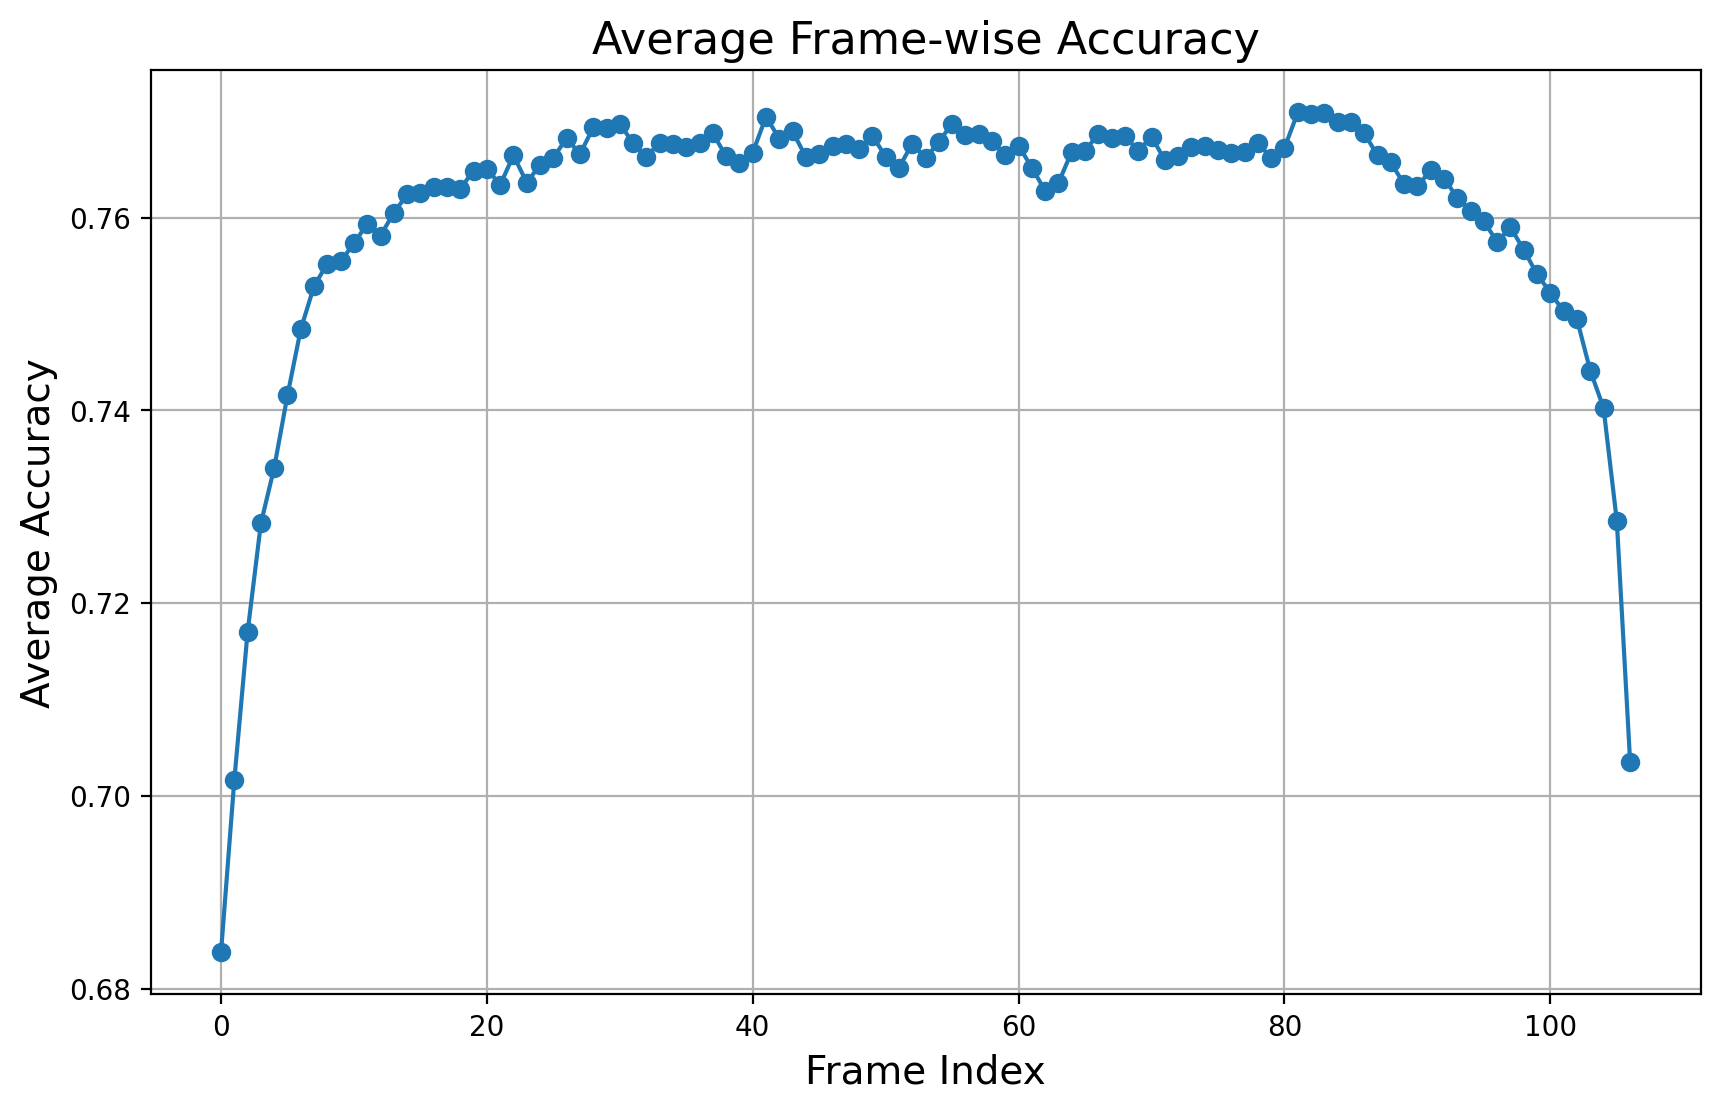

In [26]:

# Compute average accuracy per frame
frame_accuracies = frame_correct_counts / frame_total_counts

# Plot the results
import matplotlib.pyplot as plt

frames = torch.arange(num_frames)
plt.figure(figsize=(10, 6))
plt.plot(frames, frame_accuracies, marker='o')
plt.title("Average Frame-wise Accuracy", fontsize=16)
plt.xlabel("Frame Index", fontsize=14)
plt.ylabel("Average Accuracy", fontsize=14)
plt.grid(True)
plt.show()

# Training run loss Graphs

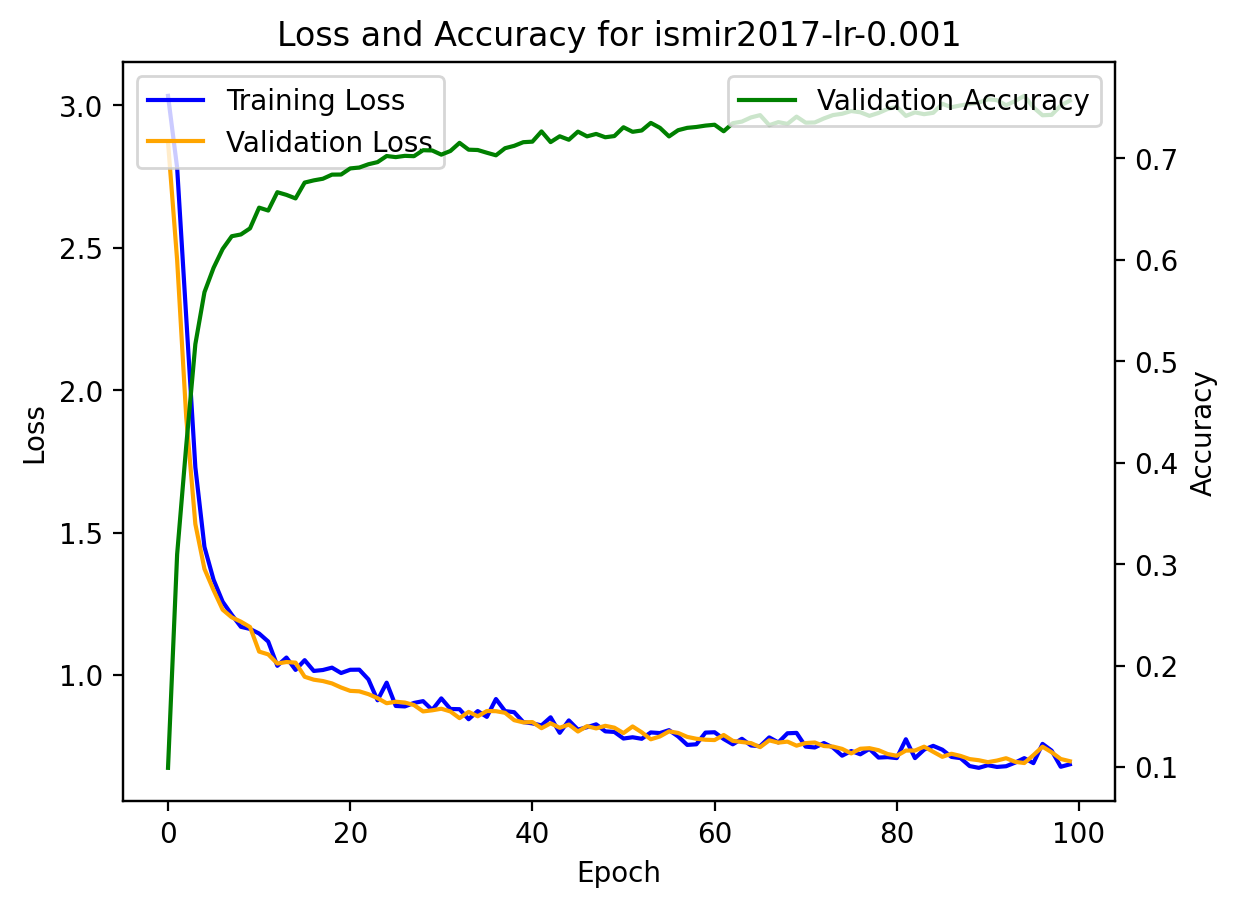

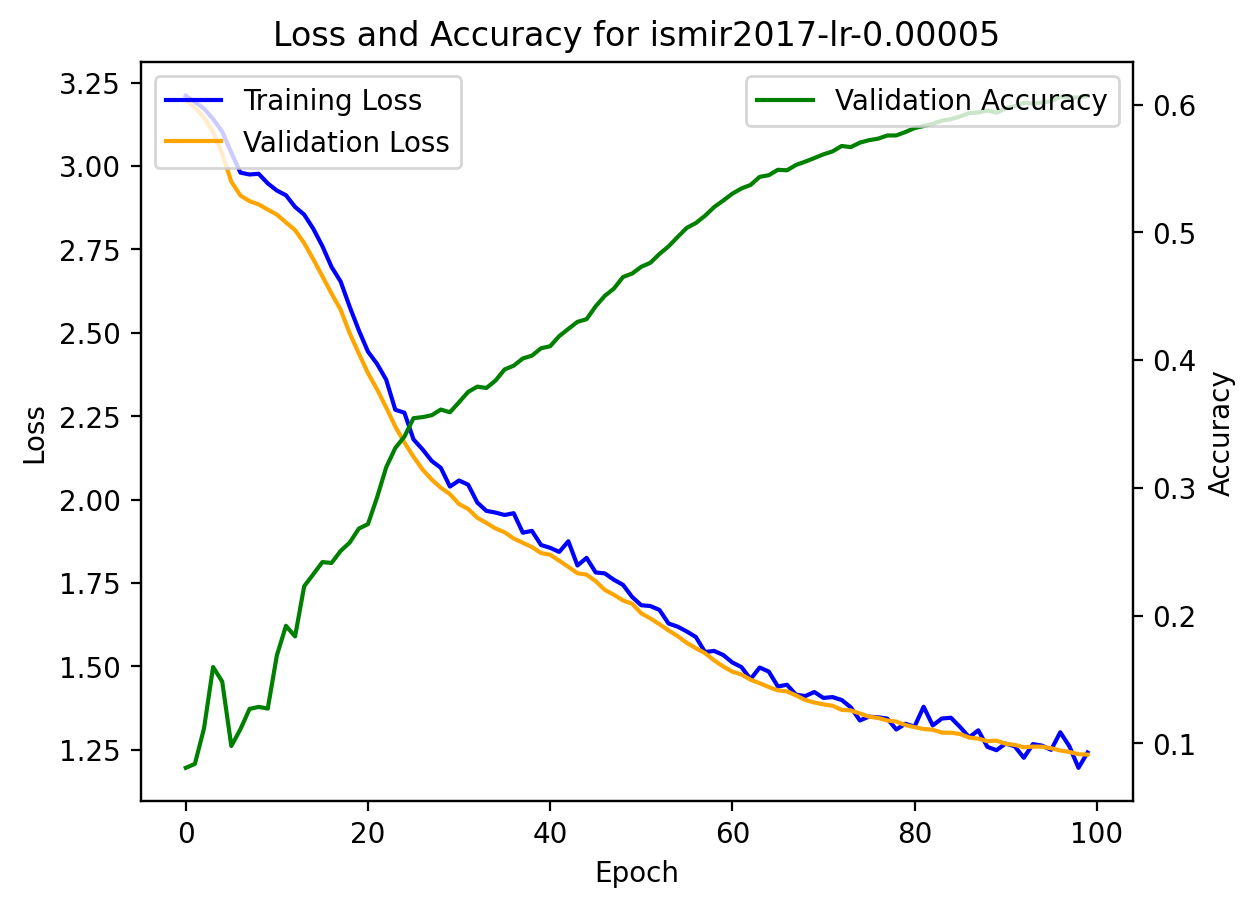

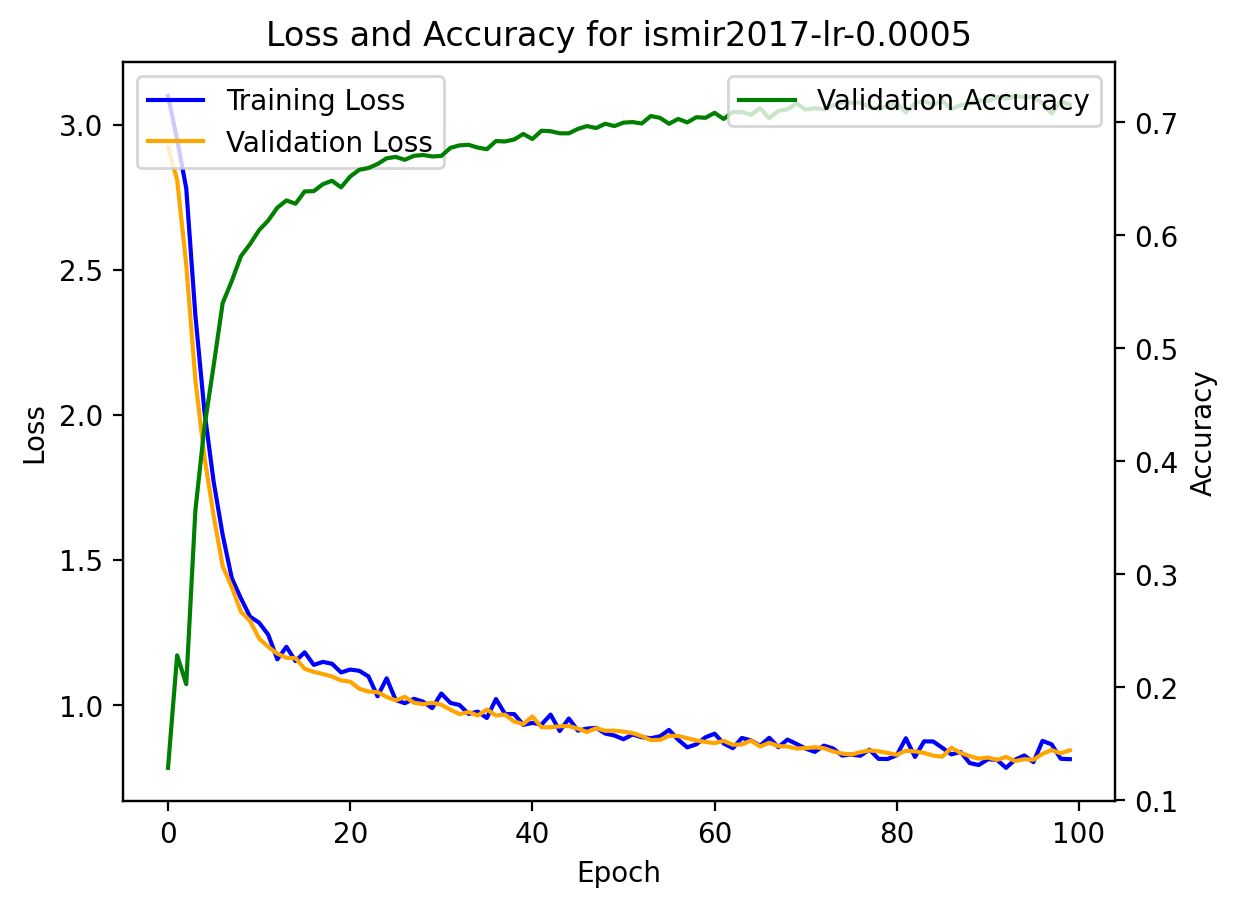

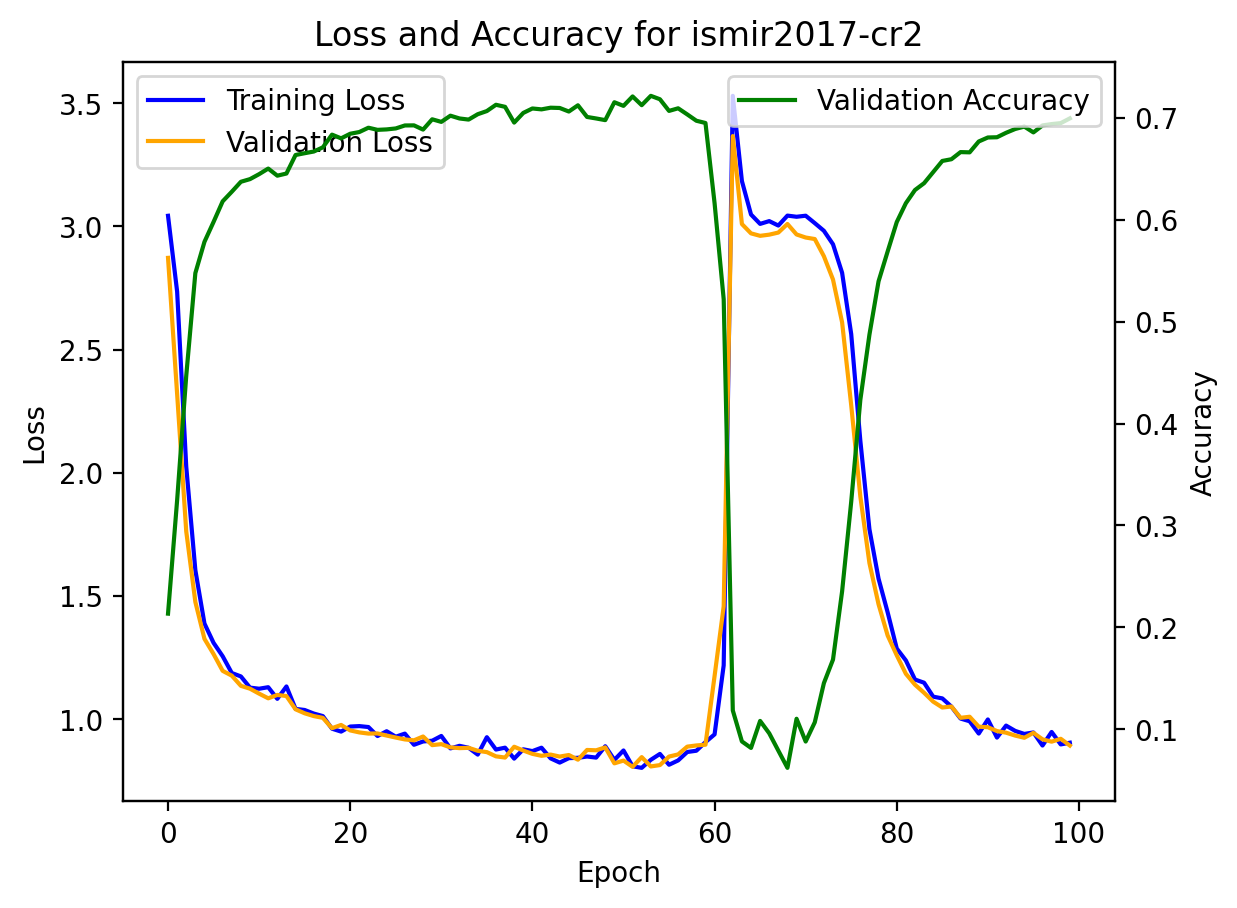

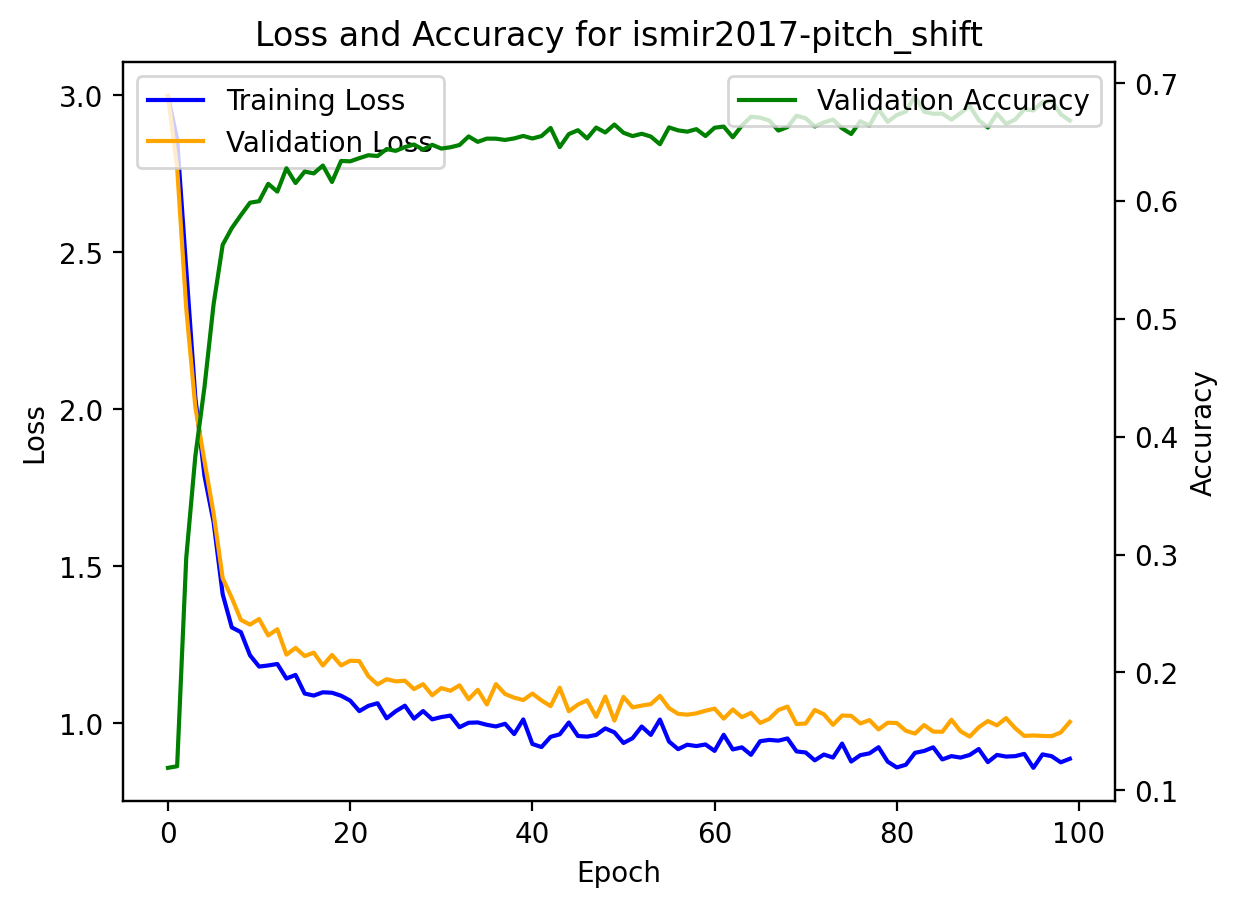

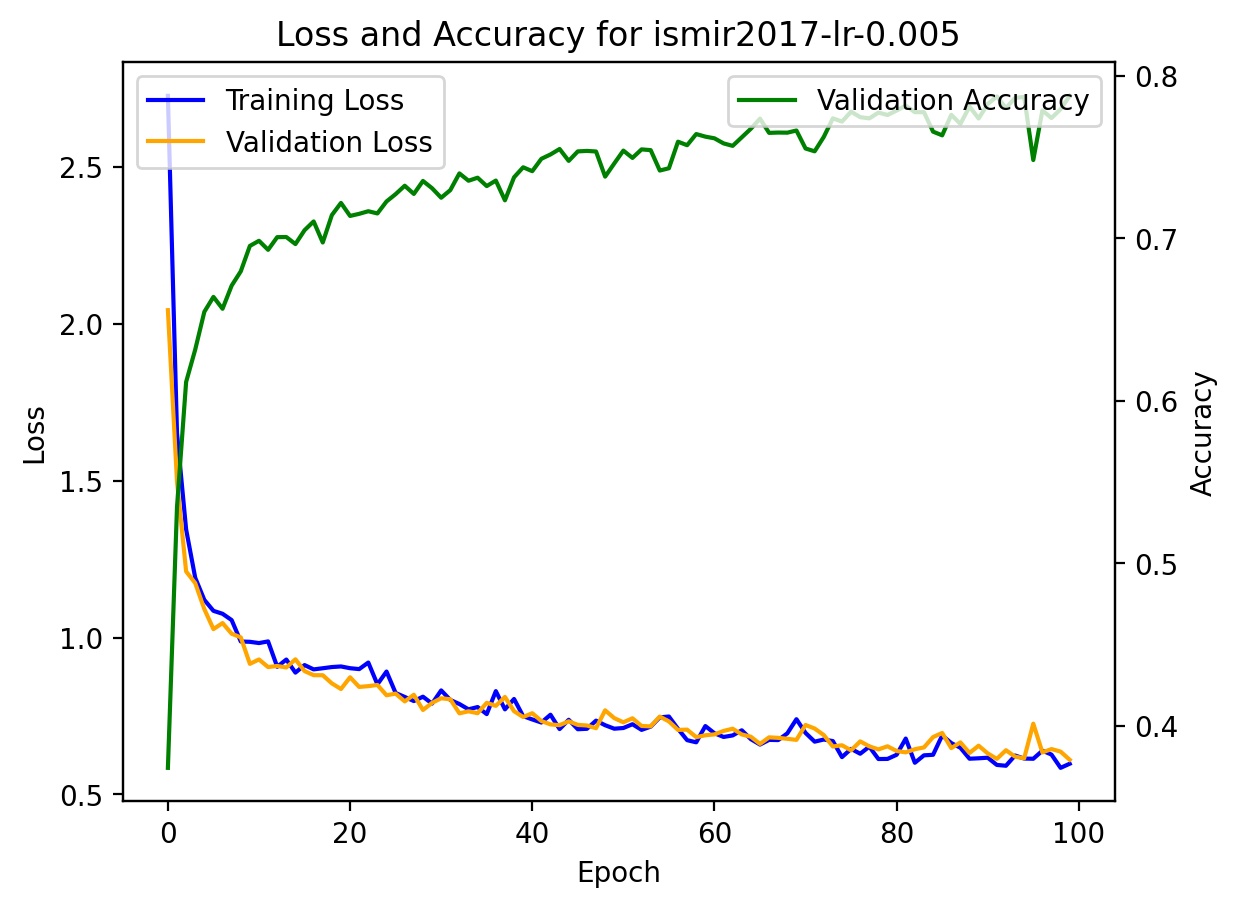

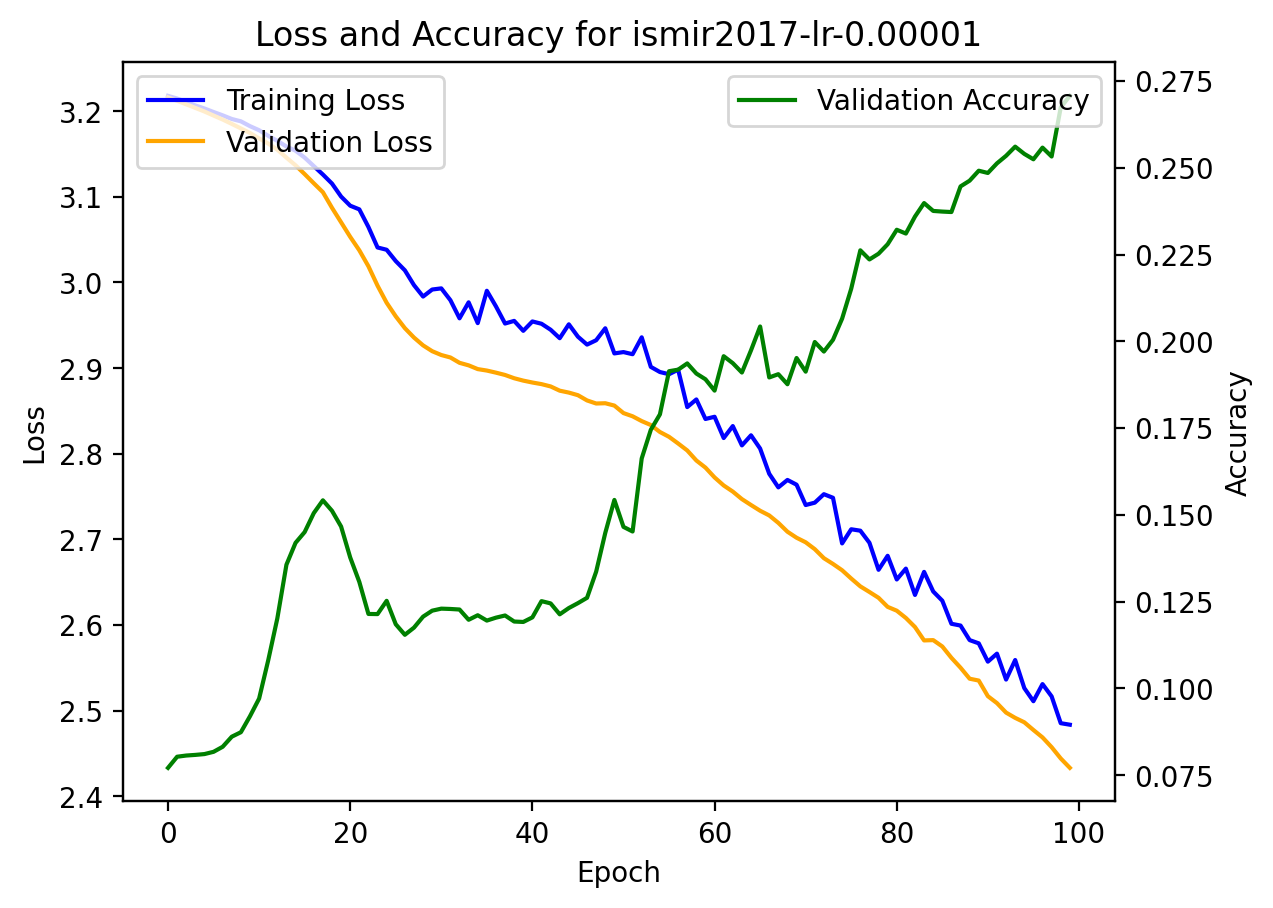

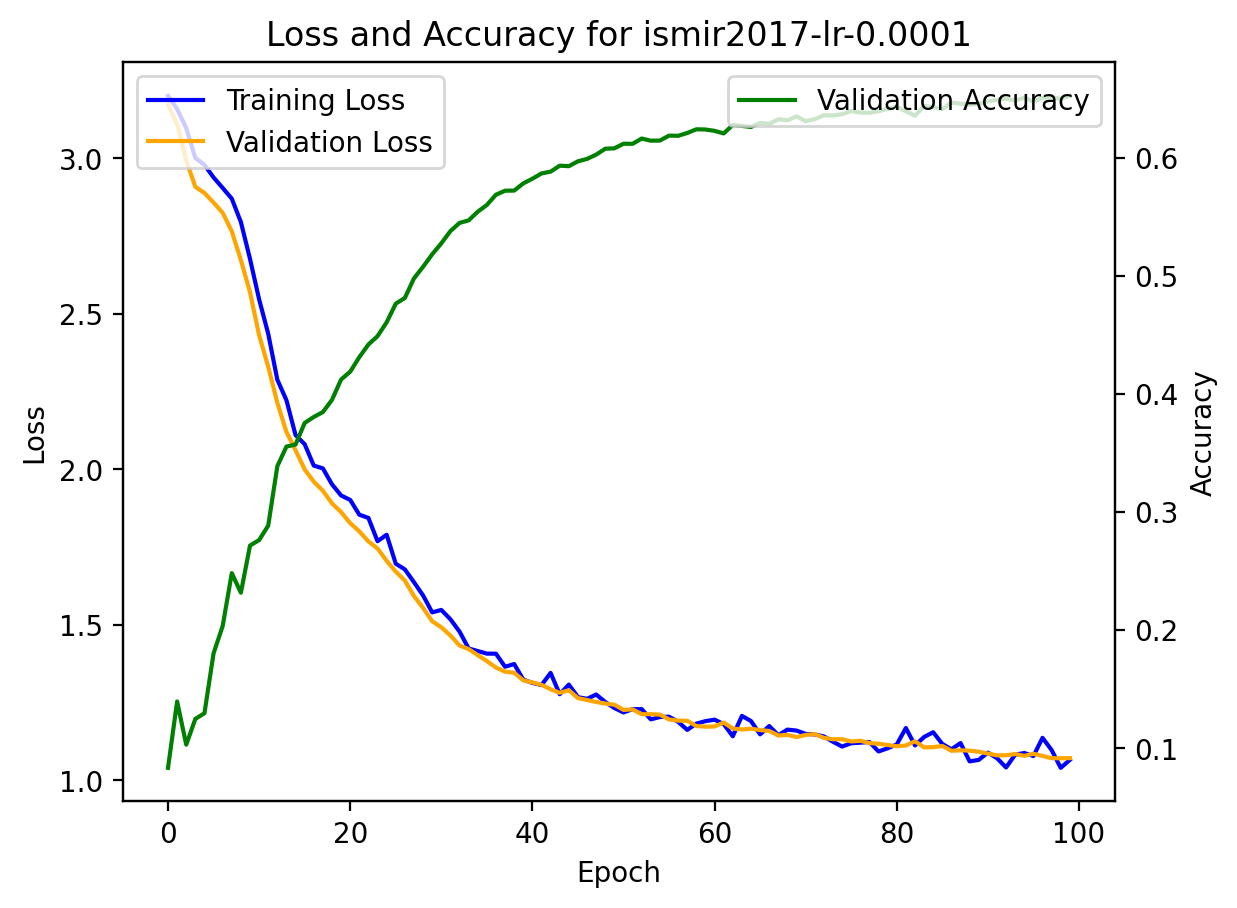

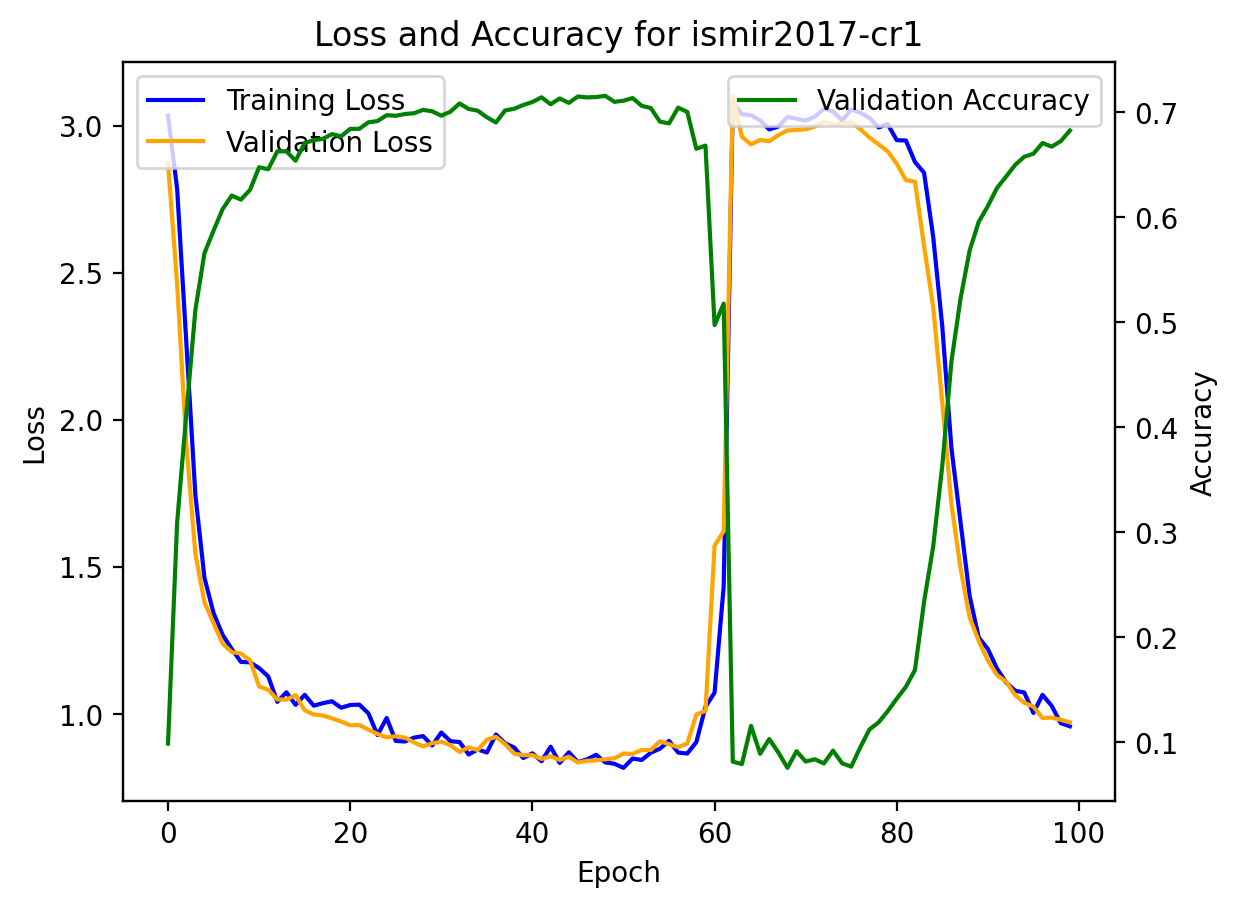

In [60]:
import json

for exp in os.listdir('./data/experiments/'):
    if not os.path.exists(f'./data/experiments/{exp}/training_history.json'):
        continue
    training_history = json.load(open(f'./data/experiments/{exp}/training_history.json'))
    train_losses = training_history['train_losses']
    val_losses = training_history['val_losses']
    val_accuracies = training_history['val_accuracies']
    # Plot all 3, with acc having its own y-axis
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='orange')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='green')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f'Loss and Accuracy for {exp}')

# Context Testing

Does it do worse near the edges of its context?

In [ ]:
for i in range(10):
    cqt, label = dataset[i]
    pred = model(cqt.unsqueeze(0))
    preds = torch.argmax(pred, dim=2)
    pred_chords = [id_to_chord_map[id] for id in preds[0].tolist()]
    label_chords = [id_to_chord_map[id] for id in label.tolist()]
    print(list(zip(pred_chords, label_chords)))

# Listening!

In [62]:
from src.utils import get_filenames

In [63]:
filenames = get_filenames()
filenames

['bobseger_rockandrollneverforgets(live)',
 'blessidunionofsouls_ibelieve',
 'robertjohn_lonelyeyes',
 'foreigner_iwanttoknowwhatloveis',
 'ericburdonandtheanimals_sanfranciscannights',
 'thebeatles_thecontinuingstoryofbungalowbill',
 'andygibb_shadowdancing',
 "heart_there'sthegirl(2000digitalremaster)",
 'the5thdimension_gowhereyouwannago',
 'davidbowie_modernlove(singleversion)(2002digitalremaster)',
 'gregkihn_happyman(live)',
 'blondie_onewayoranother',
 'bobseger_nightmoves(albumversion)',
 'thebeatles_youlikemetoomuch',
 'tevincampbell_tellmewhatyouwantmetodo(single)',
 'TRLBPGI149E33BDA3C',
 'johnnyhorton_johnnyreb',
 'thebeatles_goodmorninggoodmorning',
 'billyjoel_aninnocentman',
 'jamesbrown_getupifeellikebeingasexmachine',
 'donovan_sunshinesuperman(fullversion)(1998digitalremaster)',
 'leannrimes_ineedyou',
 'steviewonder_higherground',
 'otisredding_chainedandbound',
 'eagles_thelongrun',
 'thebeatles_abbeyroadmedley(full)',
 'TRKLGWQ149E3E580CD',
 'steviewonder_doido',
 